In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score
import os

In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [5]:
set_seed(2024)

In [6]:
# Augmentation pipeline for training
train_transforms = transforms.Compose([
#    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),   # Resized crop
    transforms.Resize((224, 224)),   # Resize to 224x224
    transforms.RandomHorizontalFlip(),                     # Horizontal flip
    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.5), saturation=(0.8, 1.3), hue=(-0.05, 0.05)),  # Color jitter
    transforms.RandomRotation(15),                         # Random rotation
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),  # Random erasing (Cutout)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

In [7]:
# Evaluation pipeline without augmentations
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Load the training dataset
train_dataset = ImageFolder(root='./train', transform=train_transforms)

# Check class-to-index mapping
print("Class-to-Index Mapping:", train_dataset.class_to_idx)

batch_size = 32
dropout_rate = 0.3

# Create a DataLoader for training
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers = 8)

# Load the testing dataset
eval_dataset = ImageFolder(root='./test', transform=eval_transforms)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False, num_workers = 8)

# Example: Accessing a sample
for images, labels in train_loader:
    print("Batch of Images:", images.shape)  # [batch_size, channels, height, width]
    print("Batch of Labels:", labels)       # Tensor of label indices
    break

Class-to-Index Mapping: {'Baked Potato': 0, 'Crispy Chicken': 1, 'Donut': 2, 'Fries': 3, 'Hot Dog': 4, 'Sandwich': 5, 'Taco': 6, 'Taquito': 7, 'apple_pie': 8, 'burger': 9, 'butter_naan': 10, 'chai': 11, 'chapati': 12, 'cheesecake': 13, 'chicken_curry': 14, 'chole_bhature': 15, 'dal_makhani': 16, 'dhokla': 17, 'fried_rice': 18, 'ice_cream': 19, 'idli': 20, 'jalebi': 21, 'kaathi_rolls': 22, 'kadai_paneer': 23, 'kulfi': 24, 'masala_dosa': 25, 'momos': 26, 'omelette': 27, 'paani_puri': 28, 'pakode': 29, 'pav_bhaji': 30, 'pizza': 31, 'samosa': 32, 'sushi': 33}
Batch of Images: torch.Size([32, 3, 224, 224])
Batch of Labels: tensor([ 8,  3, 30, 33,  6, 19,  3,  5,  4, 33,  5,  5, 31,  5, 33,  5, 10, 27,
        13, 16, 10, 13,  0, 18,  4, 14, 11, 14, 15,  4, 23,  2])


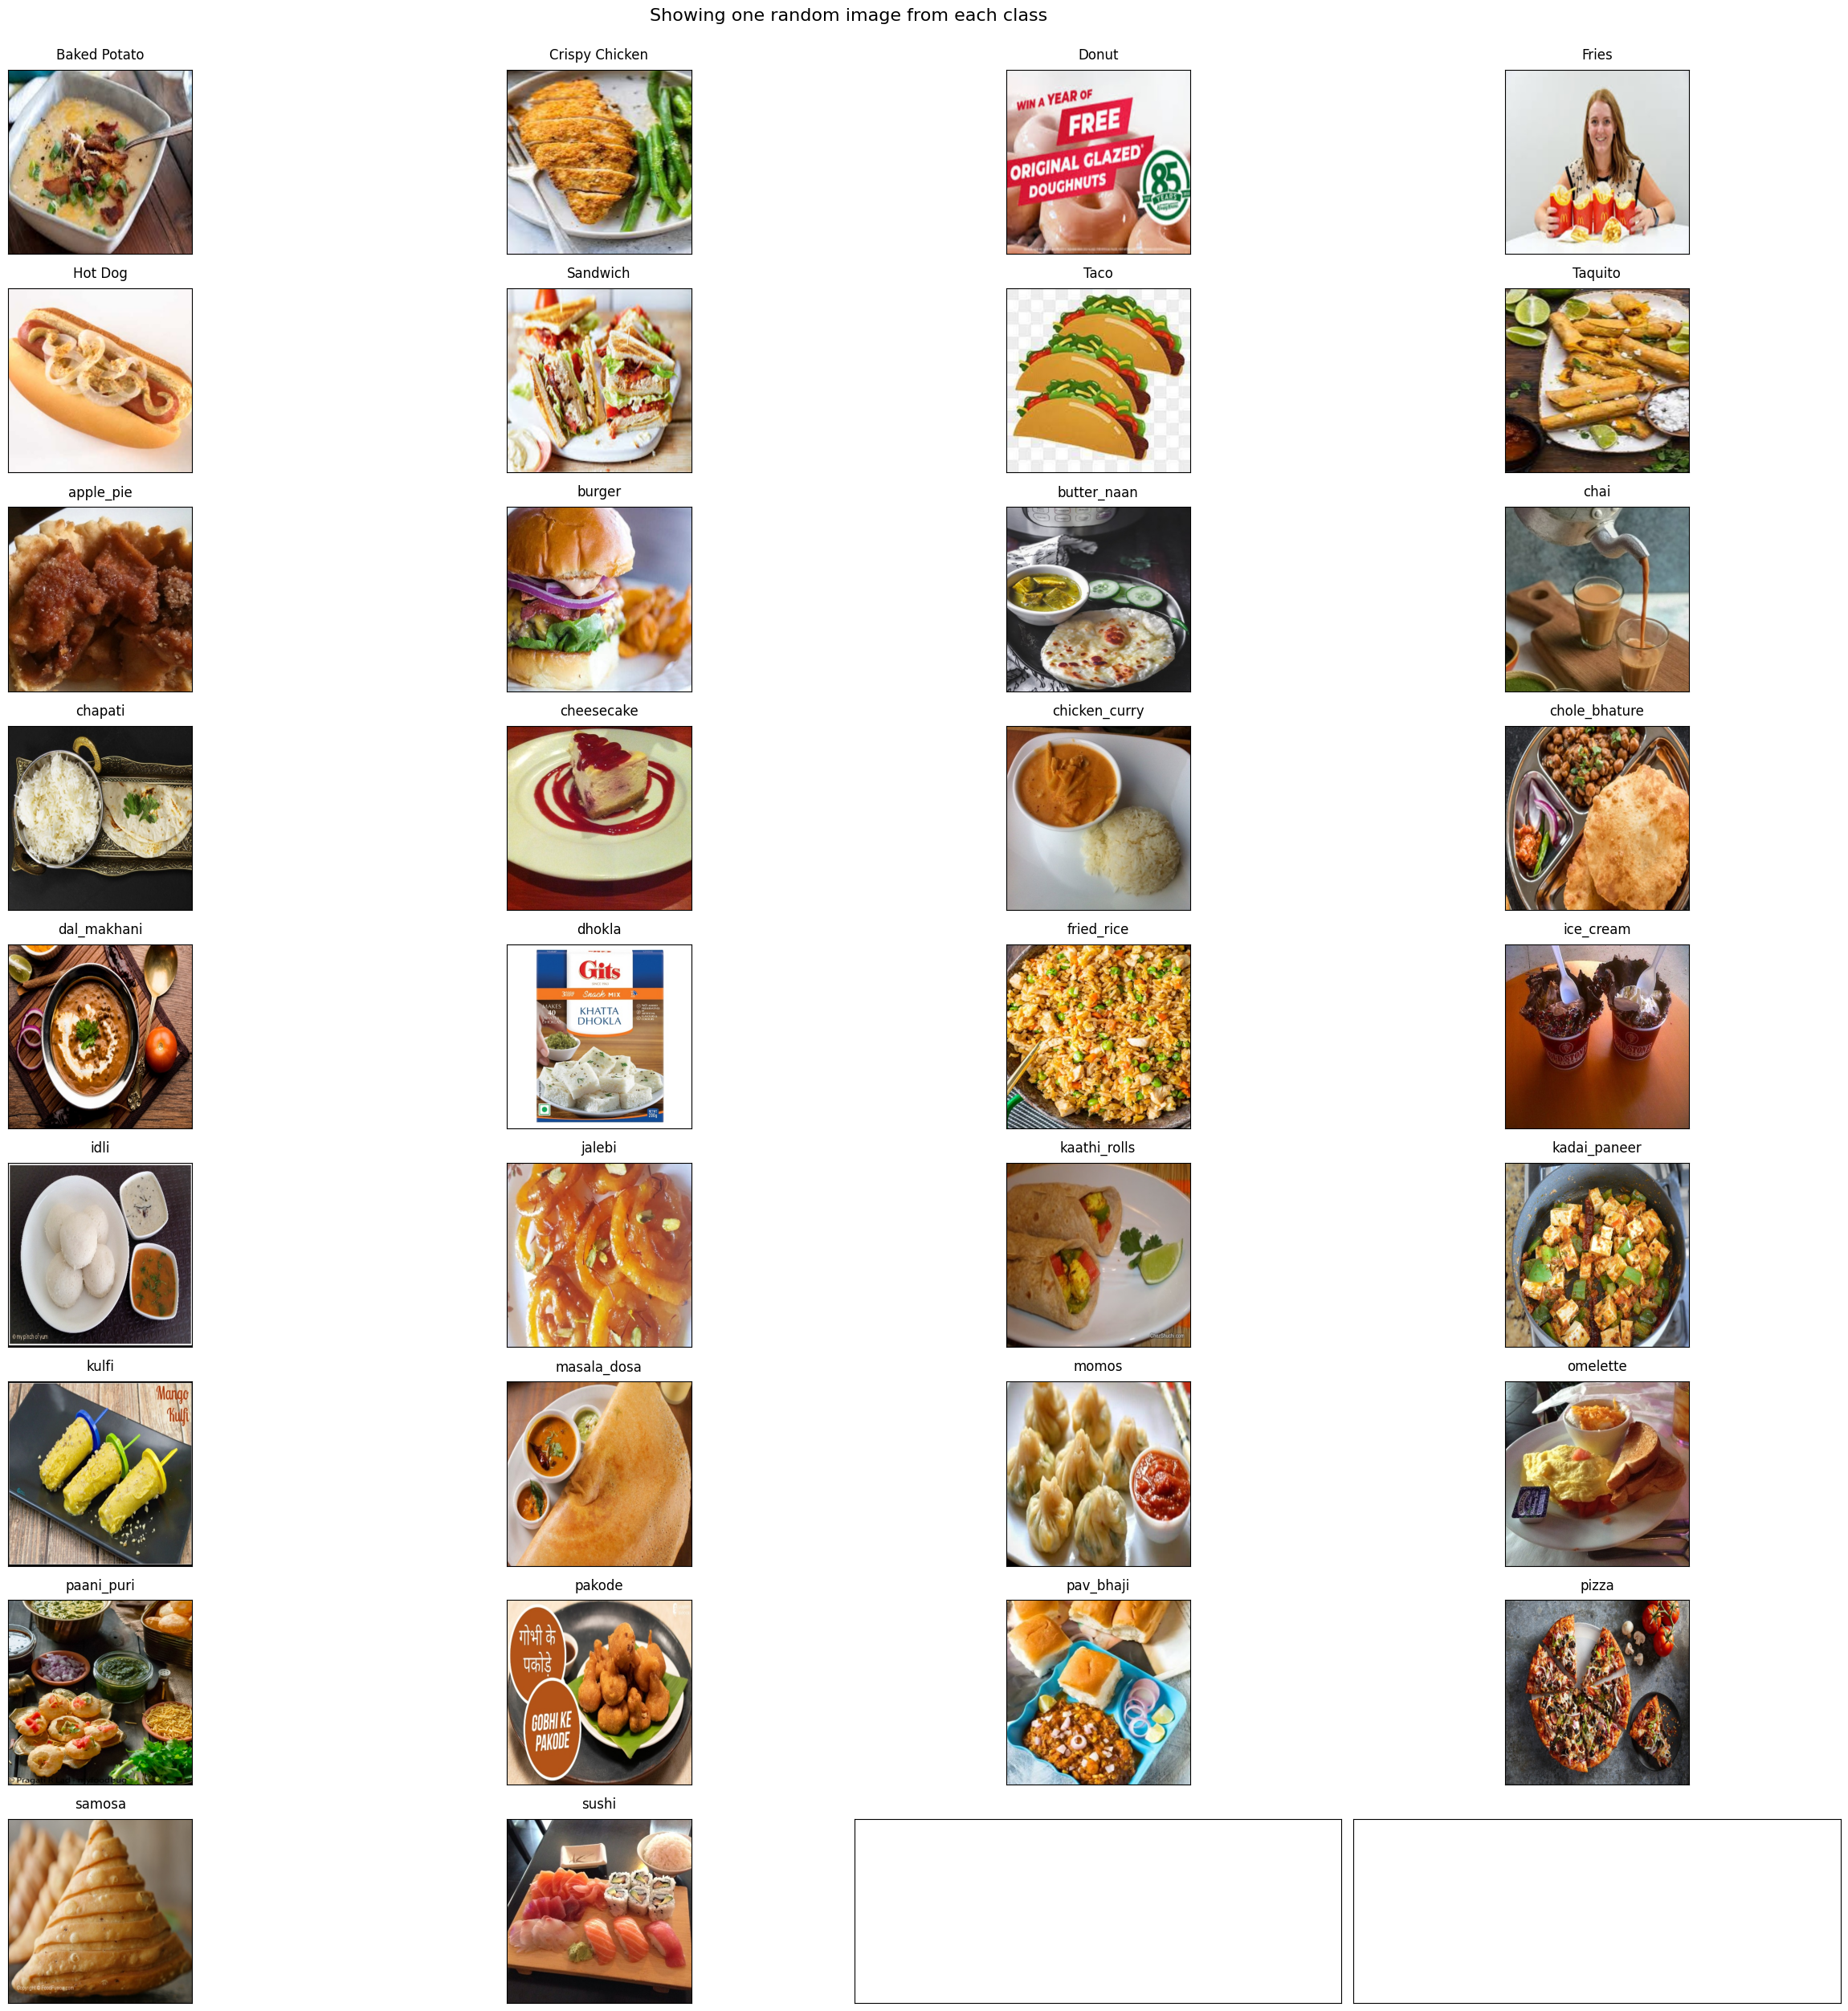

In [9]:
# Display one random image from each class
rows, cols = 9, 4
fig, ax = plt.subplots(rows, cols, figsize=(25, 25))
fig.suptitle("Showing one random image from each class", y=1, fontsize=16)
data_dir = "./train"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
    for j in range(cols):
        try:
            food_selected = foods_sorted[food_id]
            food_id += 1
        except IndexError:
            break
        food_selected_images = os.listdir(os.path.join(data_dir, food_selected))
        food_selected_random = np.random.choice(food_selected_images)
        img = plt.imread(os.path.join(data_dir, food_selected, food_selected_random))
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_selected, pad=10)
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()
plt.show()

In [10]:
# Unfrozen
class CombinedModel(nn.Module):
    def __init__(self, dropout):
        super(CombinedModel, self).__init__()

        # Load pre-trained models (ResNet50 and EfficientNet B2)
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.efficientnet = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)

        # Unfreeze all layers in both pre-trained models
        for param in self.resnet.parameters():
            param.requires_grad = True

        for param in self.efficientnet.parameters():
            param.requires_grad = True

        # Remove final classification layers from both models
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.efficientnet = nn.Sequential(*list(self.efficientnet.children())[:-1])

        # Batch normalization layer for the combined feature map
        self.bn = nn.BatchNorm1d(2048 + 1408)  # ResNet50 has 2048 features, EfficientNet B2 has 1408 features

        # Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(2048 + 1408, 2048),  # Concatenate feature vectors
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2048, 34)  # 5 output classes for multi-class classification
        )

    def forward(self, x):
        # Extract features from both models
        resnet_features = self.resnet(x).view(x.size(0), -1)  # Flatten the ResNet features
        efficientnet_features = self.efficientnet(x).view(x.size(0), -1)  # Flatten the EfficientNet features

        # Concatenate features
        combined_features = torch.cat((resnet_features, efficientnet_features), dim=1)

        # Apply batch normalization and ReLU activation after concatenation
        combined_features = self.bn(combined_features)
        combined_features = torch.relu(combined_features)

        # Pass through fully connected layers
        output = self.fc(combined_features)
        return output

In [11]:
# Initialize lists for metrics storage
train_loss_list = []
eval_loss_list = []
train_f1_list = []
eval_f1_list = []

In [12]:
# Just instantiate the model without calling it directly in the last line
model = CombinedModel(dropout=dropout_rate)

# Move model to the device (GPU/CPU), but don't return the model as the last line.
model = CombinedModel(dropout=dropout_rate).to(device)

#params
num_epochs = 50
lr = 0.001

In [13]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.4)
optimizer = optim.Adam([
    {'params': model.resnet.parameters(), 'lr': lr * 0.1, 'weight_decay': 1e-3},
    {'params': model.efficientnet.parameters(), 'lr': lr * 0.1, 'weight_decay': 1e-3},
    {'params': model.fc.parameters(), 'lr': lr, 'weight_decay': 1e-3}
])

# Scheduler for adjusting the learning rate based on validation loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [14]:
# Training loop with detailed metric output
def train_model(model, train_loader, eval_loader, criterion, optimizer, num_epochs):
    best_f1 = 0.0  # Variable to keep track of the best F1 score based on validation set

    # Lists to store metrics for plotting
    train_losses, eval_losses = [], []
    train_f1s, eval_f1s = [], []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        # Training loop
        with tqdm(total=len(train_loader), desc=f"Train Epoch [{epoch+1}/{num_epochs}]") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Calculate training metrics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Update progress bar
                pbar.update(1)

        # Calculate metrics for this epoch
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        epoch_f1_train = f1_score(all_labels, all_preds, average='macro')

        # Append metrics
        train_loss_list.append(epoch_loss)
        train_f1_list.append(epoch_f1_train)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Train F1: {epoch_f1_train:.4f}")

        # Evaluate on validation set
        eval_loss, eval_acc, eval_f1 = evaluate_model(model, eval_loader, criterion, epoch, num_epochs)
        scheduler.step(eval_loss)

        eval_loss_list.append(eval_loss)
        eval_f1_list.append(eval_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_acc:.4f}, Eval F1: {eval_f1:.4f}")

        # Check if this is the best model based on validation F1 score
        if eval_f1 > best_f1:
            best_f1 = eval_f1
            print(f"Best model saved with Eval F1: {best_f1:.4f}")
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model weights

    print(f"Training complete. Best Evaluation F1 Score: {best_f1:.4f}")

In [15]:
# Evaluation function to compute loss, accuracy, and F1 score
def evaluate_model(model, eval_loader, criterion, epoch, num_epochs):
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    running_loss = 0.0

    with tqdm(total=len(eval_loader), desc=f"Eval Epoch [{epoch+1}/{num_epochs}]") as pbar:
        with torch.no_grad():
            for inputs, labels in eval_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                # Update progress bar
                pbar.update(1)

    # Calculate loss, accuracy, and F1 score for the validation set
    eval_loss = running_loss / total
    eval_acc = correct / total
    eval_f1 = f1_score(all_labels, all_preds, average='macro')

    return eval_loss, eval_acc, eval_f1

In [16]:
# Run the training and evaluation
train_model(model, train_loader, eval_loader, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)

Train Epoch [1/50]: 100%|██████████| 597/597 [01:47<00:00,  5.55it/s]


Epoch [1/50], Train Loss: 2.6494, Train Accuracy: 0.6644, Train F1: 0.6279


Eval Epoch [1/50]: 100%|██████████| 150/150 [00:26<00:00,  5.58it/s]


Epoch [1/50], Eval Loss: 2.4047, Eval Accuracy: 0.8358, Eval F1: 0.8261
Best model saved with Eval F1: 0.8261


Train Epoch [2/50]: 100%|██████████| 597/597 [01:45<00:00,  5.63it/s]


Epoch [2/50], Train Loss: 2.4590, Train Accuracy: 0.8010, Train F1: 0.7903


Eval Epoch [2/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [2/50], Eval Loss: 2.3707, Eval Accuracy: 0.8588, Eval F1: 0.8618
Best model saved with Eval F1: 0.8618


Train Epoch [3/50]: 100%|██████████| 597/597 [01:46<00:00,  5.63it/s]


Epoch [3/50], Train Loss: 2.4129, Train Accuracy: 0.8271, Train F1: 0.8225


Eval Epoch [3/50]: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]


Epoch [3/50], Eval Loss: 2.3630, Eval Accuracy: 0.8886, Eval F1: 0.8876
Best model saved with Eval F1: 0.8876


Train Epoch [4/50]: 100%|██████████| 597/597 [01:47<00:00,  5.58it/s]


Epoch [4/50], Train Loss: 2.3881, Train Accuracy: 0.8417, Train F1: 0.8316


Eval Epoch [4/50]: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


Epoch [4/50], Eval Loss: 2.3695, Eval Accuracy: 0.8919, Eval F1: 0.8983
Best model saved with Eval F1: 0.8983


Train Epoch [5/50]: 100%|██████████| 597/597 [01:46<00:00,  5.58it/s]


Epoch [5/50], Train Loss: 2.3820, Train Accuracy: 0.8532, Train F1: 0.8476


Eval Epoch [5/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [5/50], Eval Loss: 2.3196, Eval Accuracy: 0.8894, Eval F1: 0.8901


Train Epoch [6/50]: 100%|██████████| 597/597 [01:47<00:00,  5.56it/s]


Epoch [6/50], Train Loss: 2.2830, Train Accuracy: 0.8993, Train F1: 0.8959


Eval Epoch [6/50]: 100%|██████████| 150/150 [00:26<00:00,  5.59it/s]


Epoch [6/50], Eval Loss: 2.2348, Eval Accuracy: 0.9156, Eval F1: 0.9220
Best model saved with Eval F1: 0.9220


Train Epoch [7/50]: 100%|██████████| 597/597 [01:47<00:00,  5.57it/s]


Epoch [7/50], Train Loss: 2.2536, Train Accuracy: 0.9141, Train F1: 0.9127


Eval Epoch [7/50]: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


Epoch [7/50], Eval Loss: 2.2418, Eval Accuracy: 0.9194, Eval F1: 0.9288
Best model saved with Eval F1: 0.9288


Train Epoch [8/50]: 100%|██████████| 597/597 [01:47<00:00,  5.58it/s]


Epoch [8/50], Train Loss: 2.2448, Train Accuracy: 0.9194, Train F1: 0.9179


Eval Epoch [8/50]: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


Epoch [8/50], Eval Loss: 2.3008, Eval Accuracy: 0.9137, Eval F1: 0.9227


Train Epoch [9/50]: 100%|██████████| 597/597 [01:46<00:00,  5.59it/s]


Epoch [9/50], Train Loss: 2.2456, Train Accuracy: 0.9206, Train F1: 0.9205


Eval Epoch [9/50]: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]


Epoch [9/50], Eval Loss: 2.2696, Eval Accuracy: 0.9160, Eval F1: 0.9252


Train Epoch [10/50]: 100%|██████████| 597/597 [01:46<00:00,  5.59it/s]


Epoch [10/50], Train Loss: 2.1984, Train Accuracy: 0.9407, Train F1: 0.9421


Eval Epoch [10/50]: 100%|██████████| 150/150 [00:26<00:00,  5.59it/s]


Epoch [10/50], Eval Loss: 2.2132, Eval Accuracy: 0.9250, Eval F1: 0.9363
Best model saved with Eval F1: 0.9363


Train Epoch [11/50]: 100%|██████████| 597/597 [01:47<00:00,  5.57it/s]


Epoch [11/50], Train Loss: 2.1839, Train Accuracy: 0.9482, Train F1: 0.9482


Eval Epoch [11/50]: 100%|██████████| 150/150 [00:26<00:00,  5.58it/s]


Epoch [11/50], Eval Loss: 2.2096, Eval Accuracy: 0.9280, Eval F1: 0.9376
Best model saved with Eval F1: 0.9376


Train Epoch [12/50]: 100%|██████████| 597/597 [01:47<00:00,  5.58it/s]


Epoch [12/50], Train Loss: 2.1796, Train Accuracy: 0.9495, Train F1: 0.9498


Eval Epoch [12/50]: 100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


Epoch [12/50], Eval Loss: 2.2245, Eval Accuracy: 0.9277, Eval F1: 0.9364


Train Epoch [13/50]: 100%|██████████| 597/597 [01:47<00:00,  5.58it/s]


Epoch [13/50], Train Loss: 2.1742, Train Accuracy: 0.9521, Train F1: 0.9533


Eval Epoch [13/50]: 100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


Epoch [13/50], Eval Loss: 2.2213, Eval Accuracy: 0.9257, Eval F1: 0.9346


Train Epoch [14/50]: 100%|██████████| 597/597 [01:45<00:00,  5.64it/s]


Epoch [14/50], Train Loss: 2.1514, Train Accuracy: 0.9620, Train F1: 0.9628


Eval Epoch [14/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [14/50], Eval Loss: 2.1832, Eval Accuracy: 0.9284, Eval F1: 0.9408
Best model saved with Eval F1: 0.9408


Train Epoch [15/50]: 100%|██████████| 597/597 [01:47<00:00,  5.58it/s]


Epoch [15/50], Train Loss: 2.1409, Train Accuracy: 0.9663, Train F1: 0.9669


Eval Epoch [15/50]: 100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


Epoch [15/50], Eval Loss: 2.1841, Eval Accuracy: 0.9317, Eval F1: 0.9391


Train Epoch [16/50]: 100%|██████████| 597/597 [01:47<00:00,  5.58it/s]


Epoch [16/50], Train Loss: 2.1403, Train Accuracy: 0.9665, Train F1: 0.9669


Eval Epoch [16/50]: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


Epoch [16/50], Eval Loss: 2.1934, Eval Accuracy: 0.9269, Eval F1: 0.9390


Train Epoch [17/50]: 100%|██████████| 597/597 [01:47<00:00,  5.57it/s]


Epoch [17/50], Train Loss: 2.1367, Train Accuracy: 0.9681, Train F1: 0.9681


Eval Epoch [17/50]: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]


Epoch [17/50], Eval Loss: 2.1922, Eval Accuracy: 0.9313, Eval F1: 0.9401


Train Epoch [18/50]: 100%|██████████| 597/597 [01:47<00:00,  5.57it/s]


Epoch [18/50], Train Loss: 2.1226, Train Accuracy: 0.9715, Train F1: 0.9736


Eval Epoch [18/50]: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


Epoch [18/50], Eval Loss: 2.1682, Eval Accuracy: 0.9330, Eval F1: 0.9426
Best model saved with Eval F1: 0.9426


Train Epoch [19/50]: 100%|██████████| 597/597 [01:47<00:00,  5.57it/s]


Epoch [19/50], Train Loss: 2.1188, Train Accuracy: 0.9730, Train F1: 0.9742


Eval Epoch [19/50]: 100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


Epoch [19/50], Eval Loss: 2.1695, Eval Accuracy: 0.9324, Eval F1: 0.9415


Train Epoch [20/50]: 100%|██████████| 597/597 [01:47<00:00,  5.57it/s]


Epoch [20/50], Train Loss: 2.1169, Train Accuracy: 0.9747, Train F1: 0.9761


Eval Epoch [20/50]: 100%|██████████| 150/150 [00:26<00:00,  5.59it/s]


Epoch [20/50], Eval Loss: 2.1700, Eval Accuracy: 0.9309, Eval F1: 0.9408


Train Epoch [21/50]: 100%|██████████| 597/597 [01:47<00:00,  5.57it/s]


Epoch [21/50], Train Loss: 2.1129, Train Accuracy: 0.9766, Train F1: 0.9780


Eval Epoch [21/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [21/50], Eval Loss: 2.1673, Eval Accuracy: 0.9319, Eval F1: 0.9421


Train Epoch [22/50]: 100%|██████████| 597/597 [01:46<00:00,  5.59it/s]


Epoch [22/50], Train Loss: 2.1052, Train Accuracy: 0.9787, Train F1: 0.9791


Eval Epoch [22/50]: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]


Epoch [22/50], Eval Loss: 2.1592, Eval Accuracy: 0.9328, Eval F1: 0.9423


Train Epoch [23/50]: 100%|██████████| 597/597 [01:46<00:00,  5.59it/s]


Epoch [23/50], Train Loss: 2.1045, Train Accuracy: 0.9781, Train F1: 0.9795


Eval Epoch [23/50]: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


Epoch [23/50], Eval Loss: 2.1646, Eval Accuracy: 0.9319, Eval F1: 0.9407


Train Epoch [24/50]: 100%|██████████| 597/597 [01:46<00:00,  5.59it/s]


Epoch [24/50], Train Loss: 2.1031, Train Accuracy: 0.9779, Train F1: 0.9790


Eval Epoch [24/50]: 100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


Epoch [24/50], Eval Loss: 2.1625, Eval Accuracy: 0.9324, Eval F1: 0.9407


Train Epoch [25/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [25/50], Train Loss: 2.1029, Train Accuracy: 0.9782, Train F1: 0.9789


Eval Epoch [25/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [25/50], Eval Loss: 2.1624, Eval Accuracy: 0.9296, Eval F1: 0.9401


Train Epoch [26/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [26/50], Train Loss: 2.0986, Train Accuracy: 0.9800, Train F1: 0.9811


Eval Epoch [26/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [26/50], Eval Loss: 2.1602, Eval Accuracy: 0.9313, Eval F1: 0.9396


Train Epoch [27/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [27/50], Train Loss: 2.0966, Train Accuracy: 0.9794, Train F1: 0.9812


Eval Epoch [27/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [27/50], Eval Loss: 2.1573, Eval Accuracy: 0.9328, Eval F1: 0.9430
Best model saved with Eval F1: 0.9430


Train Epoch [28/50]: 100%|██████████| 597/597 [01:46<00:00,  5.59it/s]


Epoch [28/50], Train Loss: 2.0958, Train Accuracy: 0.9804, Train F1: 0.9817


Eval Epoch [28/50]: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


Epoch [28/50], Eval Loss: 2.1555, Eval Accuracy: 0.9336, Eval F1: 0.9434
Best model saved with Eval F1: 0.9434


Train Epoch [29/50]: 100%|██████████| 597/597 [01:47<00:00,  5.56it/s]


Epoch [29/50], Train Loss: 2.0969, Train Accuracy: 0.9777, Train F1: 0.9786


Eval Epoch [29/50]: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]


Epoch [29/50], Eval Loss: 2.1594, Eval Accuracy: 0.9317, Eval F1: 0.9416


Train Epoch [30/50]: 100%|██████████| 597/597 [01:47<00:00,  5.57it/s]


Epoch [30/50], Train Loss: 2.0922, Train Accuracy: 0.9818, Train F1: 0.9825


Eval Epoch [30/50]: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


Epoch [30/50], Eval Loss: 2.1568, Eval Accuracy: 0.9349, Eval F1: 0.9438
Best model saved with Eval F1: 0.9438


Train Epoch [31/50]: 100%|██████████| 597/597 [01:47<00:00,  5.57it/s]


Epoch [31/50], Train Loss: 2.0911, Train Accuracy: 0.9824, Train F1: 0.9846


Eval Epoch [31/50]: 100%|██████████| 150/150 [00:26<00:00,  5.64it/s]


Epoch [31/50], Eval Loss: 2.1576, Eval Accuracy: 0.9328, Eval F1: 0.9432


Train Epoch [32/50]: 100%|██████████| 597/597 [01:46<00:00,  5.58it/s]


Epoch [32/50], Train Loss: 2.0934, Train Accuracy: 0.9816, Train F1: 0.9824


Eval Epoch [32/50]: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]


Epoch [32/50], Eval Loss: 2.1566, Eval Accuracy: 0.9321, Eval F1: 0.9421


Train Epoch [33/50]: 100%|██████████| 597/597 [01:46<00:00,  5.58it/s]


Epoch [33/50], Train Loss: 2.0908, Train Accuracy: 0.9832, Train F1: 0.9842


Eval Epoch [33/50]: 100%|██████████| 150/150 [00:26<00:00,  5.59it/s]


Epoch [33/50], Eval Loss: 2.1573, Eval Accuracy: 0.9330, Eval F1: 0.9420


Train Epoch [34/50]: 100%|██████████| 597/597 [01:47<00:00,  5.57it/s]


Epoch [34/50], Train Loss: 2.0913, Train Accuracy: 0.9824, Train F1: 0.9842


Eval Epoch [34/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [34/50], Eval Loss: 2.1549, Eval Accuracy: 0.9317, Eval F1: 0.9428


Train Epoch [35/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [35/50], Train Loss: 2.0899, Train Accuracy: 0.9833, Train F1: 0.9836


Eval Epoch [35/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [35/50], Eval Loss: 2.1572, Eval Accuracy: 0.9305, Eval F1: 0.9419


Train Epoch [36/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [36/50], Train Loss: 2.0898, Train Accuracy: 0.9823, Train F1: 0.9825


Eval Epoch [36/50]: 100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


Epoch [36/50], Eval Loss: 2.1565, Eval Accuracy: 0.9321, Eval F1: 0.9431


Train Epoch [37/50]: 100%|██████████| 597/597 [01:46<00:00,  5.60it/s]


Epoch [37/50], Train Loss: 2.0876, Train Accuracy: 0.9836, Train F1: 0.9848


Eval Epoch [37/50]: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]


Epoch [37/50], Eval Loss: 2.1587, Eval Accuracy: 0.9277, Eval F1: 0.9378


Train Epoch [38/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [38/50], Train Loss: 2.0898, Train Accuracy: 0.9828, Train F1: 0.9841


Eval Epoch [38/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [38/50], Eval Loss: 2.1557, Eval Accuracy: 0.9315, Eval F1: 0.9418


Train Epoch [39/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [39/50], Train Loss: 2.0883, Train Accuracy: 0.9832, Train F1: 0.9840


Eval Epoch [39/50]: 100%|██████████| 150/150 [00:26<00:00,  5.65it/s]


Epoch [39/50], Eval Loss: 2.1556, Eval Accuracy: 0.9324, Eval F1: 0.9433


Train Epoch [40/50]: 100%|██████████| 597/597 [01:46<00:00,  5.60it/s]


Epoch [40/50], Train Loss: 2.0895, Train Accuracy: 0.9832, Train F1: 0.9845


Eval Epoch [40/50]: 100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


Epoch [40/50], Eval Loss: 2.1552, Eval Accuracy: 0.9342, Eval F1: 0.9435


Train Epoch [41/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [41/50], Train Loss: 2.0888, Train Accuracy: 0.9840, Train F1: 0.9854


Eval Epoch [41/50]: 100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


Epoch [41/50], Eval Loss: 2.1555, Eval Accuracy: 0.9309, Eval F1: 0.9406


Train Epoch [42/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [42/50], Train Loss: 2.0883, Train Accuracy: 0.9835, Train F1: 0.9839


Eval Epoch [42/50]: 100%|██████████| 150/150 [00:26<00:00,  5.65it/s]


Epoch [42/50], Eval Loss: 2.1557, Eval Accuracy: 0.9298, Eval F1: 0.9401


Train Epoch [43/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [43/50], Train Loss: 2.0877, Train Accuracy: 0.9828, Train F1: 0.9843


Eval Epoch [43/50]: 100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


Epoch [43/50], Eval Loss: 2.1539, Eval Accuracy: 0.9315, Eval F1: 0.9416


Train Epoch [44/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [44/50], Train Loss: 2.0876, Train Accuracy: 0.9826, Train F1: 0.9829


Eval Epoch [44/50]: 100%|██████████| 150/150 [00:26<00:00,  5.62it/s]


Epoch [44/50], Eval Loss: 2.1564, Eval Accuracy: 0.9303, Eval F1: 0.9406


Train Epoch [45/50]: 100%|██████████| 597/597 [01:46<00:00,  5.62it/s]


Epoch [45/50], Train Loss: 2.0876, Train Accuracy: 0.9820, Train F1: 0.9825


Eval Epoch [45/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [45/50], Eval Loss: 2.1554, Eval Accuracy: 0.9307, Eval F1: 0.9403


Train Epoch [46/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [46/50], Train Loss: 2.0871, Train Accuracy: 0.9835, Train F1: 0.9842


Eval Epoch [46/50]: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


Epoch [46/50], Eval Loss: 2.1564, Eval Accuracy: 0.9305, Eval F1: 0.9395


Train Epoch [47/50]: 100%|██████████| 597/597 [01:46<00:00,  5.61it/s]


Epoch [47/50], Train Loss: 2.0896, Train Accuracy: 0.9828, Train F1: 0.9836


Eval Epoch [47/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [47/50], Eval Loss: 2.1546, Eval Accuracy: 0.9332, Eval F1: 0.9425


Train Epoch [48/50]: 100%|██████████| 597/597 [01:46<00:00,  5.60it/s]


Epoch [48/50], Train Loss: 2.0860, Train Accuracy: 0.9855, Train F1: 0.9857


Eval Epoch [48/50]: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]


Epoch [48/50], Eval Loss: 2.1567, Eval Accuracy: 0.9326, Eval F1: 0.9418


Train Epoch [49/50]: 100%|██████████| 597/597 [01:47<00:00,  5.55it/s]


Epoch [49/50], Train Loss: 2.0864, Train Accuracy: 0.9849, Train F1: 0.9860


Eval Epoch [49/50]: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


Epoch [49/50], Eval Loss: 2.1571, Eval Accuracy: 0.9334, Eval F1: 0.9420


Train Epoch [50/50]: 100%|██████████| 597/597 [01:47<00:00,  5.55it/s]


Epoch [50/50], Train Loss: 2.0894, Train Accuracy: 0.9828, Train F1: 0.9833


Eval Epoch [50/50]: 100%|██████████| 150/150 [00:27<00:00,  5.50it/s]

Epoch [50/50], Eval Loss: 2.1559, Eval Accuracy: 0.9330, Eval F1: 0.9426
Training complete. Best Evaluation F1 Score: 0.9438


In [17]:
# Plot metrics
def plot_metrics():
    epochs = list(range(1, num_epochs + 1))

    plt.figure(figsize=(12, 8))

    # Plot Training and Evaluation Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss_list, label='Train Loss')
    plt.plot(epochs, eval_loss_list, label='Eval Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss')
    plt.legend()

    # Plot Training and Evaluation F1 Score
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_f1_list, label='Train F1')
    plt.plot(epochs, eval_f1_list, label='Eval F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training and Evaluation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

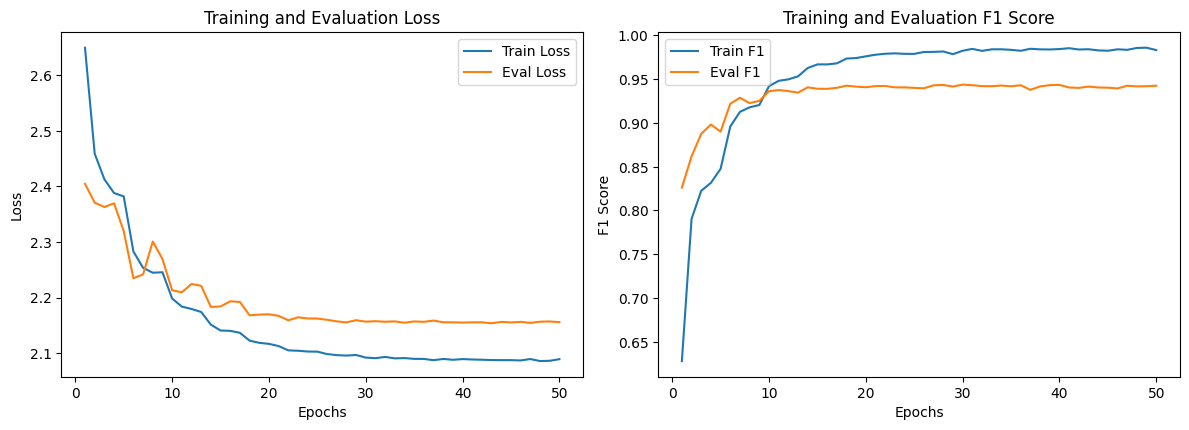

In [18]:
plot_metrics()